# New approach

In [1]:
import torch 

from PIL import Image, ImageFilter
import os
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random

## Функции для аугументации
надеюсь не сделал слишком много ошибок в слове аргументации или как его там  

Зачем?  
обычные функции из трансформа не оч подходят тк нужно изменть и пикчу и маску 

In [2]:
class RandomRotationWithMask(transforms.RandomRotation):
    def __call__(self, img, mask):
        angle = self.get_params(self.degrees)
        return transforms.functional.rotate(img, angle), transforms.functional.rotate(mask, angle)
    
class RandomHFlipWithMask:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img, mask):
        if random.random() < self.p:
            return transforms.functional.hflip(img), transforms.functional.hflip(mask)
        return img, mask
    
class RandomVFlipWithMask:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img, mask):
        if random.random() < self.p:
            return transforms.functional.vflip(img), transforms.functional.vflip(mask)
        return img, mask


class RandomBlurWithMask:
    def __init__(self, blur_radius = 2):
        self.blur_radius = blur_radius
    def __call__(self, img, mask):
        return transforms.functional.gaussian_blur(img, self.blur_radius), mask


class RandomNoiseWithMask:
    def __init__(self, p=0.2):
        self.p = p
    def __call__(self, img, mask):
        noise = torch.randn_like(img)*self.p
        return img+noise, mask


Пример трансформации каждой из функции 

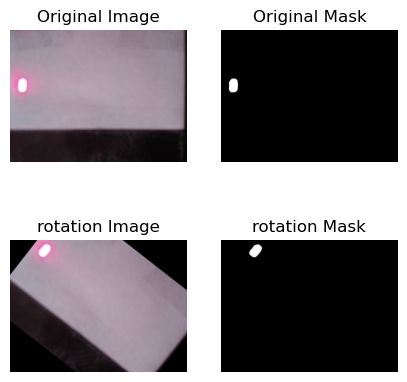

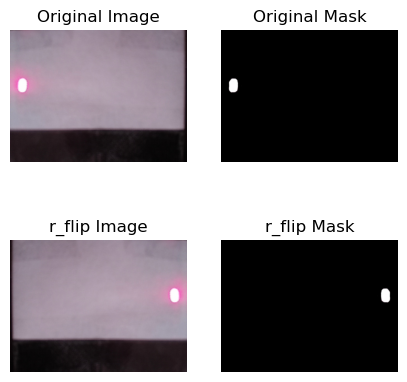

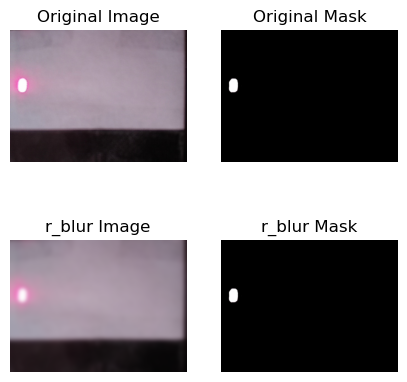

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


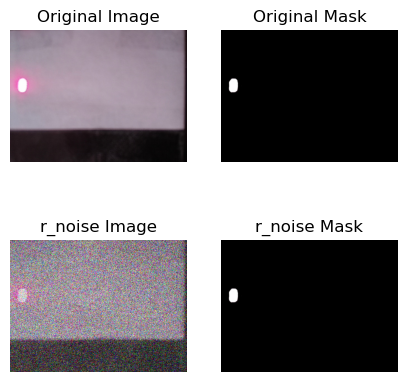

In [3]:
image_path = "laser/img_1.jpeg"
mask_path = "laser_seg/img_1.jpg"

tot = transforms.ToTensor()

image = tot(Image.open(image_path))
mask = tot(Image.open(mask_path))

r_rotation = RandomRotationWithMask(degrees=45)
random_flip = RandomHFlipWithMask(p=1)
random_blur = RandomBlurWithMask(blur_radius=41)
random_noise = RandomNoiseWithMask(p=0.5)



for transf, name in zip([r_rotation, random_flip, random_blur, random_noise], ['rotation', 'r_flip', 'r_blur', 'r_noise']):
    transformed_image, transformed_mask = transf(image, mask)
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    axs[0, 0].imshow(image.permute(1, 2, 0))
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(mask.permute(1, 2, 0), cmap='gray')
    axs[0, 1].set_title('Original Mask')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(transformed_image.permute(1, 2, 0))
    axs[1, 0].set_title(f'{name} Image')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(transformed_mask.permute(1, 2, 0), cmap='gray')
    axs[1, 1].set_title(f'{name} Mask')
    axs[1, 1].axis('off')

    plt.show()

# Dataset для нашего лазера

In [4]:
import torchvision.transforms.functional as F

In [5]:
class LaserDS(Dataset):
    def __init__(self, source_path, seg_path, image_size = 256, transform = None, use_augumentation=True):
        
        self.source_path = source_path
        self.source_file_names = [file for file in os.listdir(source_path) if not file.endswith('.npz')]
        
        self.seg_path = seg_path
        self.seg_file_names = [file for file in os.listdir(seg_path) if not file.endswith('.npz')]

        self.image_size = image_size


        self.len = len(self.source_file_names)

        r_rotation = RandomRotationWithMask(degrees=45)
        r_hflip = RandomHFlipWithMask(p=0.5)
        r_vflip = RandomVFlipWithMask(p=0.5)
        #random_shear = RandomShearWithMask(degrees=(-30, 30))
        self.r_blur = RandomBlurWithMask(blur_radius=11)
        self.r_noise = RandomNoiseWithMask(p=0.2)
        
        if transform is None:
            transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],), 
                            transforms.Resize((self.image_size, self.image_size), antialias=True),
                        ])
        self.transform = transform
        self.use_augumentation = use_augumentation
        if use_augumentation:
            self.my_trans = [r_rotation, r_hflip, r_vflip]
        else:
            self.my_trans = []

    def __len__(self):
        return self.len
    
    def __getitem__(self, indx):
        img_name = self.source_file_names[indx]
        mask_name = self.seg_file_names[indx]

        img_full_path =  os.path.join(self.source_path, img_name)
        mask_full_path =  os.path.join(self.seg_path, mask_name)

        img_t = self.transform(Image.open(img_full_path))
        mask = self.transform(Image.open(mask_full_path))

        threshold = 128

        # Бинаризация изображения
        mask = torch.mean(mask, dim=0, keepdim=True)
        mask = torch.where(mask > threshold/255.0, torch.tensor(1.0), torch.tensor(0.0))

        for transf in self.my_trans:
            img_t, mask = transf(img_t, mask)
        
        # <todo> fix it - I will definitely do it
        if self.use_augumentation:
            i = int(torch.rand(1)*10)
            if i % 3 == 0:
                img_t, mask = self.r_blur(img_t, mask)
            if i % 3 == 1:
                img_t, mask = self.r_noise(img_t, mask)

        return img_t, mask

In [6]:
dataset = LaserDS(source_path='laser', seg_path='laser_seg')
print(len(dataset))
print(dataset[0][0].shape, dataset[0][1].shape)

# val_ds without custom transformations
val_ds = LaserDS(source_path='laser', seg_path='laser_seg', use_augumentation=False)
print(len(val_ds))
print(val_ds[0][0].shape, val_ds[0][1].shape)

8
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
8
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


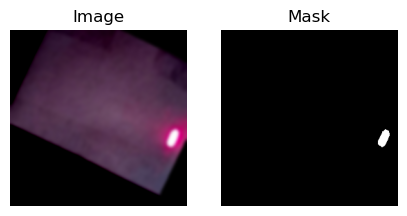

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


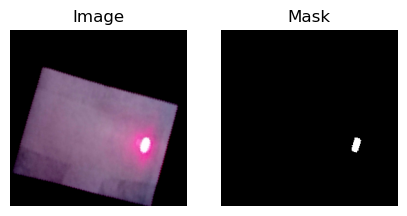

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


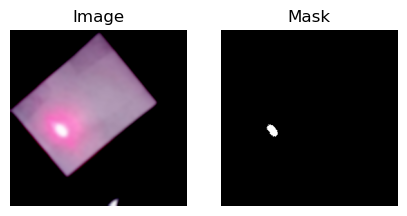

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


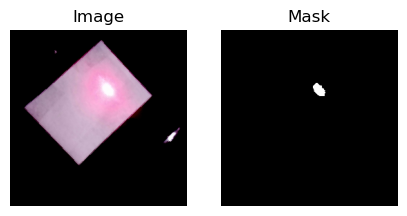

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


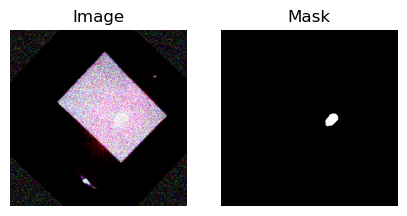

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


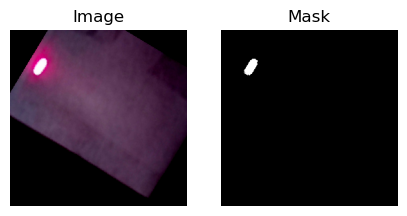

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


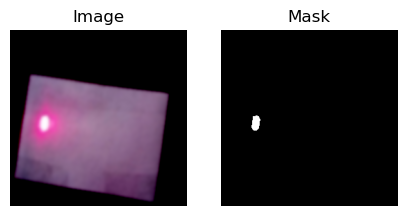

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


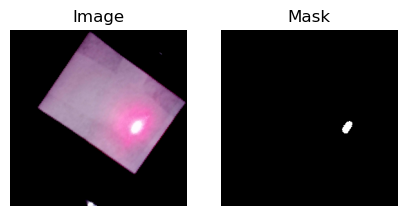

In [7]:
for img, mask in dataset:
    fig, axs = plt.subplots(1, 2, figsize=(5, 5))

    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask.permute(1, 2, 0), cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

In [8]:
from torch.utils.data import DataLoader
batch_size = 1

data_tr = DataLoader(dataset,
                      batch_size=batch_size, shuffle=True)

## Обучение, Unet и еще разные функции
Я скопировал свой старый код, лучше тут не вникать 

In [98]:
def show_real_and_fake(model, dataset, clr_output=True, threshold = None):

    if clr_output:
        clear_output(wait=True)
    std = mean = 0.5
    model.eval()
    plt.figure(figsize=(12, 6))
    len_len = min(10, len(dataset))
    for i in range(len_len):

        img, mask = dataset[i]

        with torch.no_grad():
            pred_mask = model(torch.unsqueeze(img.to(device, dtype=torch.float), 0))
        mask = mask.cpu()
        pred_mask = pred_mask.cpu()[0]
        img = img.cpu()
        #print(pred_mask)
        if threshold is not None:
            pred_mask = pred_mask >= threshold
        #mask = mask * std + mean
        #pred_mask = pred_mask * std + mean
        img = img * std + mean
        
        
        plt.subplot(3, len_len, i+1)
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
        plt.title('Real')

        plt.subplot(3, len_len, i+len_len + 1)
        plt.axis("off")
        plt.imshow(mask.permute(1, 2, 0), cmap='gray')
        plt.title('Mask')

        plt.subplot(3, len_len, i+len_len*2 + 1)
        plt.axis("off")
        plt.imshow(pred_mask.permute(1, 2, 0), cmap='gray')
        plt.title('Pred Mask')

    plt.show()


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

import numpy as np




class ConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last_block=False):
        super().__init__()

        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append( nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))

        if not is_last_block:
            layers.append(nn.ReLU())
        self.lay = nn.Sequential(*layers)


    def forward(self, x):
        return self.lay(x)

class Smoother(nn.Module):
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold

    def forward(self, x):
        binary_image = (x > self.threshold).float()

        # Определение структурого элемента (3x3 окно)
        kernel = torch.ones(1, 1, 3, 3).to(x.device)

        # Применение операции свертки для подсчета суммы значений в 3x3 окрестности
        neighbor_sum = F.conv2d(binary_image, kernel, padding=1)

        # Создание маски: пиксели, у которых сумма в окрестности >= 3, становятся белыми
        mask = (neighbor_sum >= 7).float()

        # Применение маски к бинарному изображению
        filtered_image = binary_image * mask

        return filtered_image

def score_model(model, metric, data, treshold=0.5, show_plots=True, smooth_amout=0):
    #3#
    smooth_it = Smoother()

    X_val, Y_val = next(iter(data))
    model.eval()  # testing mode
    with torch.no_grad():
        Y_hat = model(X_val.to(device)).cpu().detach()

    Y_hat = Y_hat > 0.5
    for i in range(smooth_amout):
        Y_hat = smooth_it(Y_hat)


    if show_plots:
    # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Pred')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('True')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow(Y_val[k, 0].byte() & Y_hat[k, 0].byte(), cmap='gray')
            plt.title('Intersec')
            plt.axis('off')
        #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    #3#
    model.eval()  # переводим модель в режим тестирования
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            # Отправляем данные на устройство (GPU, если доступно)
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            # Прямой проход (forward pass) для получения предсказаний
            Y_pred = model(X_batch) > treshold # treshold to binarize matrix
            for i in range(smooth_amout):
                Y_pred = smooth_it(Y_pred)
            # Вычисляем метрику на текущем батче и суммируем

            scores += metric(Y_label, Y_pred).mean().item()

    # Возвращаем усредненную метрику по всем батчам
    return scores / len(data)

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    #print(iou)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

def train(model, opt, loss_fn, epochs, data_tr, data_val, val_ds, show_plots=True):
    counter = 0
    losses = []
    val_acc = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            #print('1loss: %f' % loss)
        toc = time()
        print('loss: %f' % avg_loss)
        losses.append(loss)

        clear_output(wait=True)        

        counter += 1
        if show_plots and counter % 10 == 0:
            # show intermediate results
            model.eval()  # testing mode
            show_real_and_fake(model=model, dataset=val_ds)

        val_score = score_model(model, iou_pytorch, data_val, show_plots=False)
        print('val score', val_score)
        val_acc.append(val_score)
        #print('val_acc', val_acc)
    return losses, val_acc

def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

def show_plot(data: torch.Tensor, title: str, xlabel: str, ylabel: str):
    for i in range(len(data)):
        data[i] = float(data[i])
        
    plt.figure(figsize=(9, 3))
    plt.grid(True)
    plt.plot(data)
    # Добавляем заголовок и метки осей
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Отображаем график
    plt.show()

def model_full_score(model, ds_dict, treshold=0.5, show_plots=True, smooth_amout=0):
    for ds_name, ds in ds_dict.items():
        score = score_model(model,
                            iou_pytorch,
                            ds,
                            show_plots=show_plots,
                            smooth_amout=smooth_amout)
        print(ds_name, f"{score:.4f}")

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = ConvNormBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = ConvNormBlock(16, 32)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = ConvNormBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = ConvNormBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = ConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = ConvNormBlock(128, 64)

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = ConvNormBlock(64, 32)

        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = ConvNormBlock(32, 16)

        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = ConvNormBlock(16, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e, poll_ind0 = self.pool0(e0)

        e1 = self.enc_conv1(e)
        e, poll_ind1 = self.pool1(e1)

        e2 = self.enc_conv2(e)
        e, poll_ind2 = self.pool2(e2)

        e3 = self.enc_conv3(e)
        e, poll_ind3 = self.pool3(e3)

        # bottleneck <1>
        b = self.bottleneck_conv(e)

        # decoder
        d = self.dec_conv0(self.upsample0(b, indices=poll_ind3) + e3)
        d = self.dec_conv1(self.upsample1(d, indices=poll_ind2) + e2)
        d = self.dec_conv2(self.upsample2(d, indices=poll_ind1) + e1)
        d = self.dec_conv3(self.upsample3(d, indices=poll_ind0) + e0)  # no activation
        return torch.sigmoid(d)

In [12]:
def dice_loss(y_real, y_pred):
    smooth =  1e-8
    num = 2 * (y_real * y_pred).sum()
    den = y_real.sum() + y_pred.sum()
    res = 1 - 1/(256*256) * ((num + smooth) / (den + smooth))
    return res

In [13]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))

    # Усредняем потери по всем примерам
    loss = torch.mean(loss)

    return loss

In [14]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):

    summand1 = torch.pow((1 - y_pred), gamma) * y_real * torch.log(y_pred + eps)
    summand2 = (1 - y_pred) * torch.log(1 - y_pred + eps)

    loss = -torch.sum(summand1 + summand2) / y_pred.size(0)
    #y_pred =  # hint: torch.clamp # чет я не понял зачем это, но когда словлю ошибку пойму
    #print(summand1)
    #print(summand2)
    return loss

class FocalLoss:
    def __init__(self, gamma = 2):
        self.gamma = gamma
    def __call__(self, y_real, y_pred):

        return focal_loss(y_real, y_pred, gamma=self.gamma)

In [49]:
def dice_loss(pred, target):
    smooth = 1.0
    intersection = (pred * target).sum() * 2
    union = pred.sum() + target.sum() + smooth
    #print('inter', intersection, 'union', union)
    dice_coefficient = (2.0 * intersection + smooth) / union
    return 1.0 - dice_coefficient


In [74]:
def dice_focal(pred, target):
    return dice_loss(pred, target)*10000 + focal_loss(pred, target, gamma=3)

In [104]:
unet2_model = UNet().to(device)

Тут я тестил разные подходы, через бок внизу результаты лучшего 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


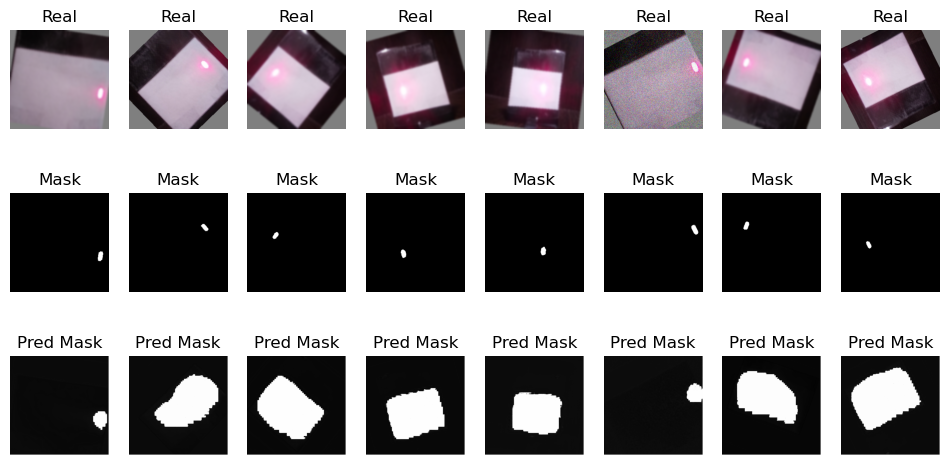

val score 0.0


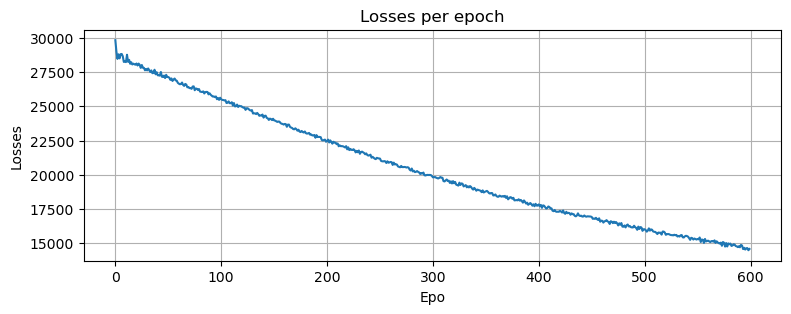

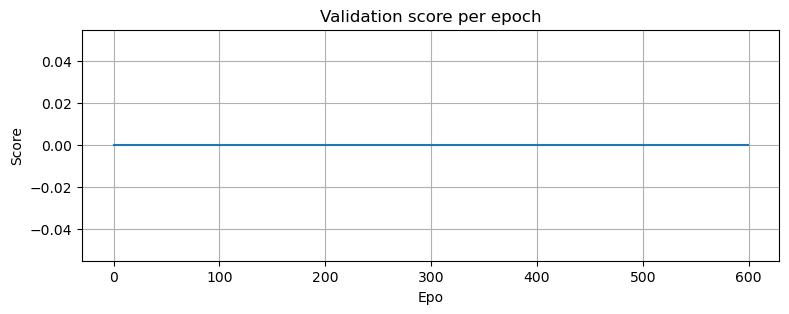

In [105]:
#loss = bce_loss
#loss = nn.BCELoss()
#loss = dice_loss
#loss = FocalLoss(gamma=3)
loss = dice_focal


max_epochs = 600
optim = torch.optim.Adam(unet2_model.parameters(), lr=3e-4)


losses, val_scores = train(unet2_model, optim, loss, max_epochs, data_tr, data_val=data_tr, val_ds=dataset, show_plots=True)

#model_full_score(unet2_model, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

больше 600 эпох ставить нет смысла (FocalLoss)
при gamma = 3 порядок лосса 18000

## это для dice_focal loss + epo=600

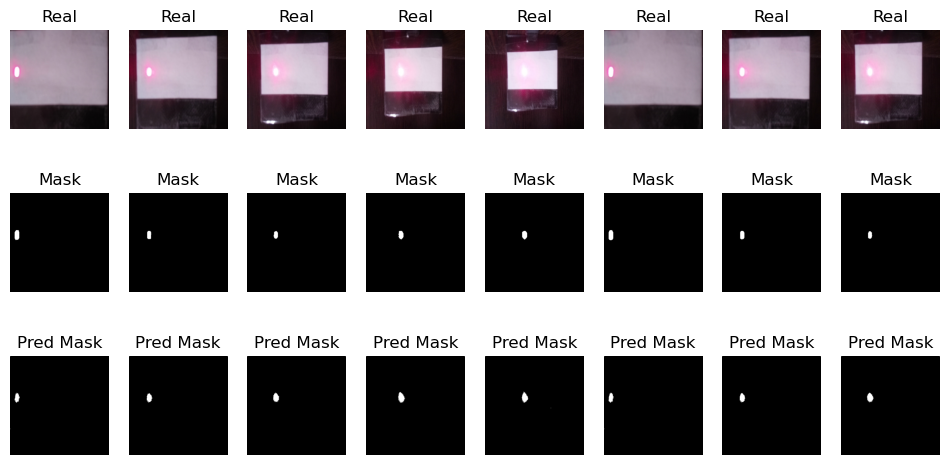

In [94]:
show_real_and_fake(model=unet2_model, dataset=val_ds, threshold = 0.985)